In [ ]:
import re
import csv
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import urllib.request 
from bs4 import BeautifulSoup

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [14]:
# Step 1: Fetch the webpage content using requests
url = "https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Step 2: Extract article content
# You'll need to adjust the tag and class based on the webpage's structure.
article_content = soup.find_all(['p', 'div'], class_=re.compile('article|body|text'))

# Join the text of all paragraphs and divs containing the article's main content
article_text = '\n'.join([tag.get_text() for tag in article_content])

# Step 3: Clean the article text using regular expressions
cleaned_text = re.sub(r'\s+', ' ', article_text).strip()  # Replace multiple spaces with a single space

# Remove any unwanted legal or copyright notices (adjust regex as needed)
cleaned_text = re.sub(r'(© \d{4} Cable News Network.*?All Rights Reserved.*?CNN Sans ™ & .*)', '', cleaned_text, flags=re.DOTALL)
cleaned_text = re.sub(r'(Most stock quote data provided.*?CNN)', '', cleaned_text, flags=re.DOTALL)

# Step 4: Split the cleaned article into sentences using spaCy
doc = nlp(cleaned_text)

# Extract sentences from the spaCy document
sentences = [sent.text.strip() for sent in doc.sents]

# Step 5: Save the sentences to a CSV file
with open("cleaned_article_sentences.csv", "w", newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Sentence"])  # Header row
    for sentence in sentences:
        writer.writerow([sentence])

print("Article sentences have been saved to 'cleaned_article_sentences.csv'")


Article sentences have been saved to 'cleaned_article_sentences.csv'


In [15]:
csv_sentences = pd.read_csv("cleaned_article_sentences.csv")

In [31]:
def clean_and_extract_entities(sentence):
    ent1 = ""
    ent2 = ""
    
    # Tokenize the sentence and filter based on entity types and dependencies
    doc = nlp(sentence)
    
    subject = None
    object_ = None
    
    for token in doc:
        # Skip pronouns, auxiliary verbs, and other non-entities
        if token.pos_ in ['PRON', 'AUX', 'DET', 'ADP', 'PART']:
            continue

        # If token is part of a noun or proper noun phrase
        if 'subj' in token.dep_ and token.pos_ in ['PROPN', 'NOUN']:  # subject (proper noun or noun)
            subject = token.text
        elif 'obj' in token.dep_ and token.pos_ in ['PROPN', 'NOUN']:  # object (proper noun or noun)
            object_ = token.text

    # Ensure that both subject and object are found
    if subject and object_:
        ent1 = subject
        ent2 = object_
    
    return [ent1.strip(), ent2.strip()]

In [32]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [33]:
sentences = csv_sentences['Sentence'].tolist()  

In [34]:
# Define list for storing relations
relations = []
entity_pairs = []

# Loop over sentences to extract entities and relations
for sentence in sentences:
    entity_pair = get_entities(sentence)
    relation = get_relation(sentence)
    
    # Check if entity_pair contains valid entities (not empty)
    if entity_pair[0] and entity_pair[1]:
        entity_pairs.append(entity_pair)
        relations.append(relation)

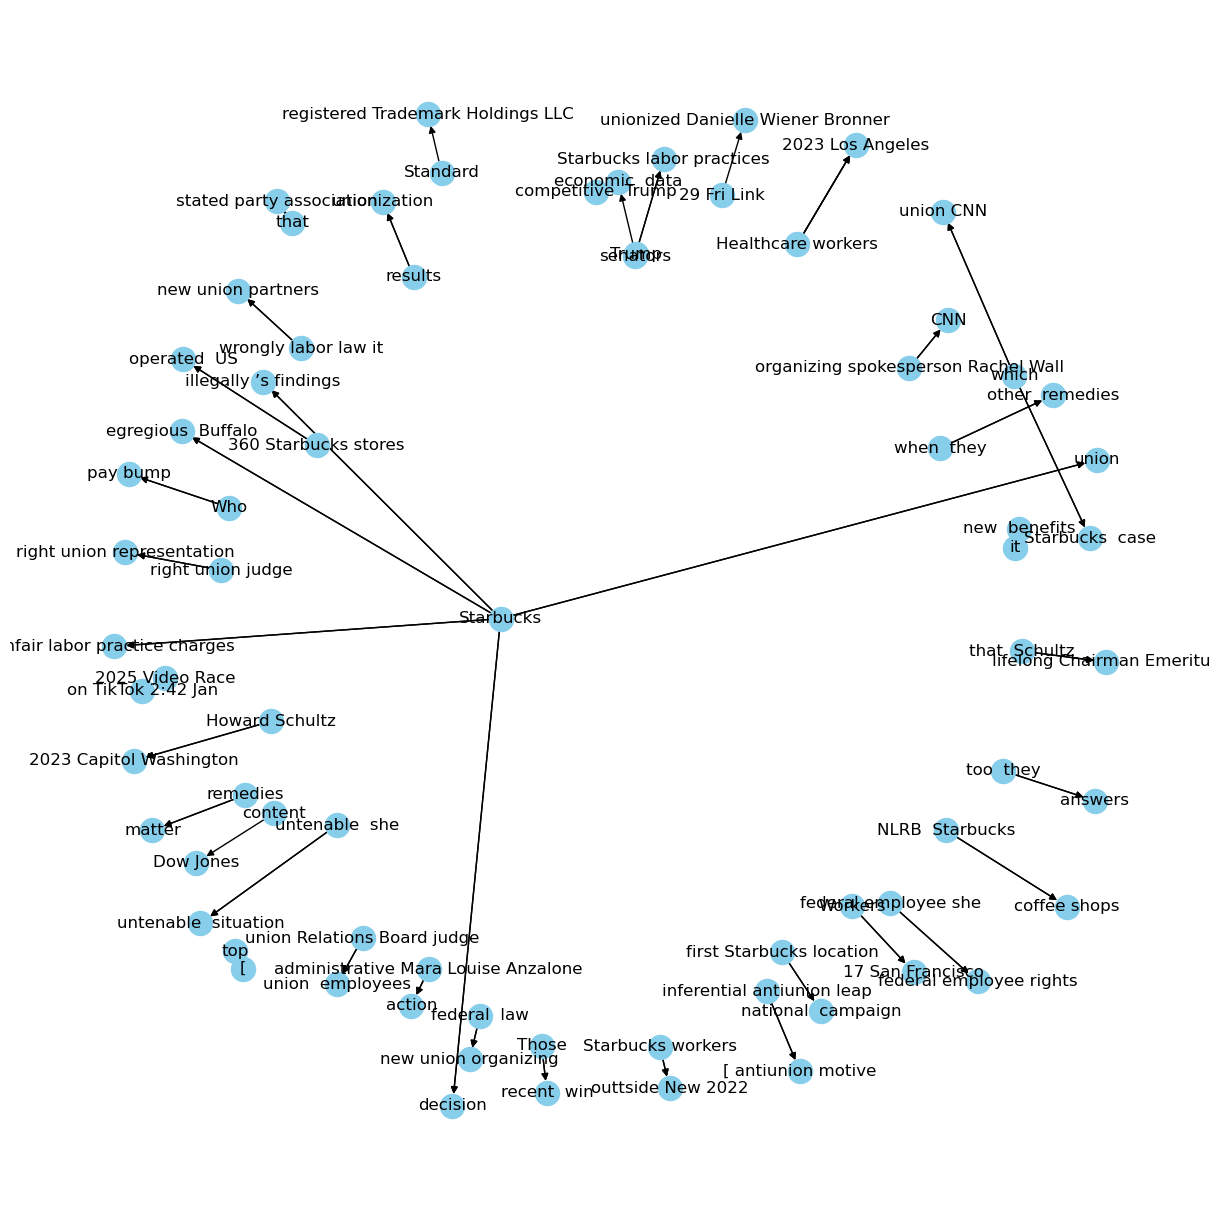

In [35]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

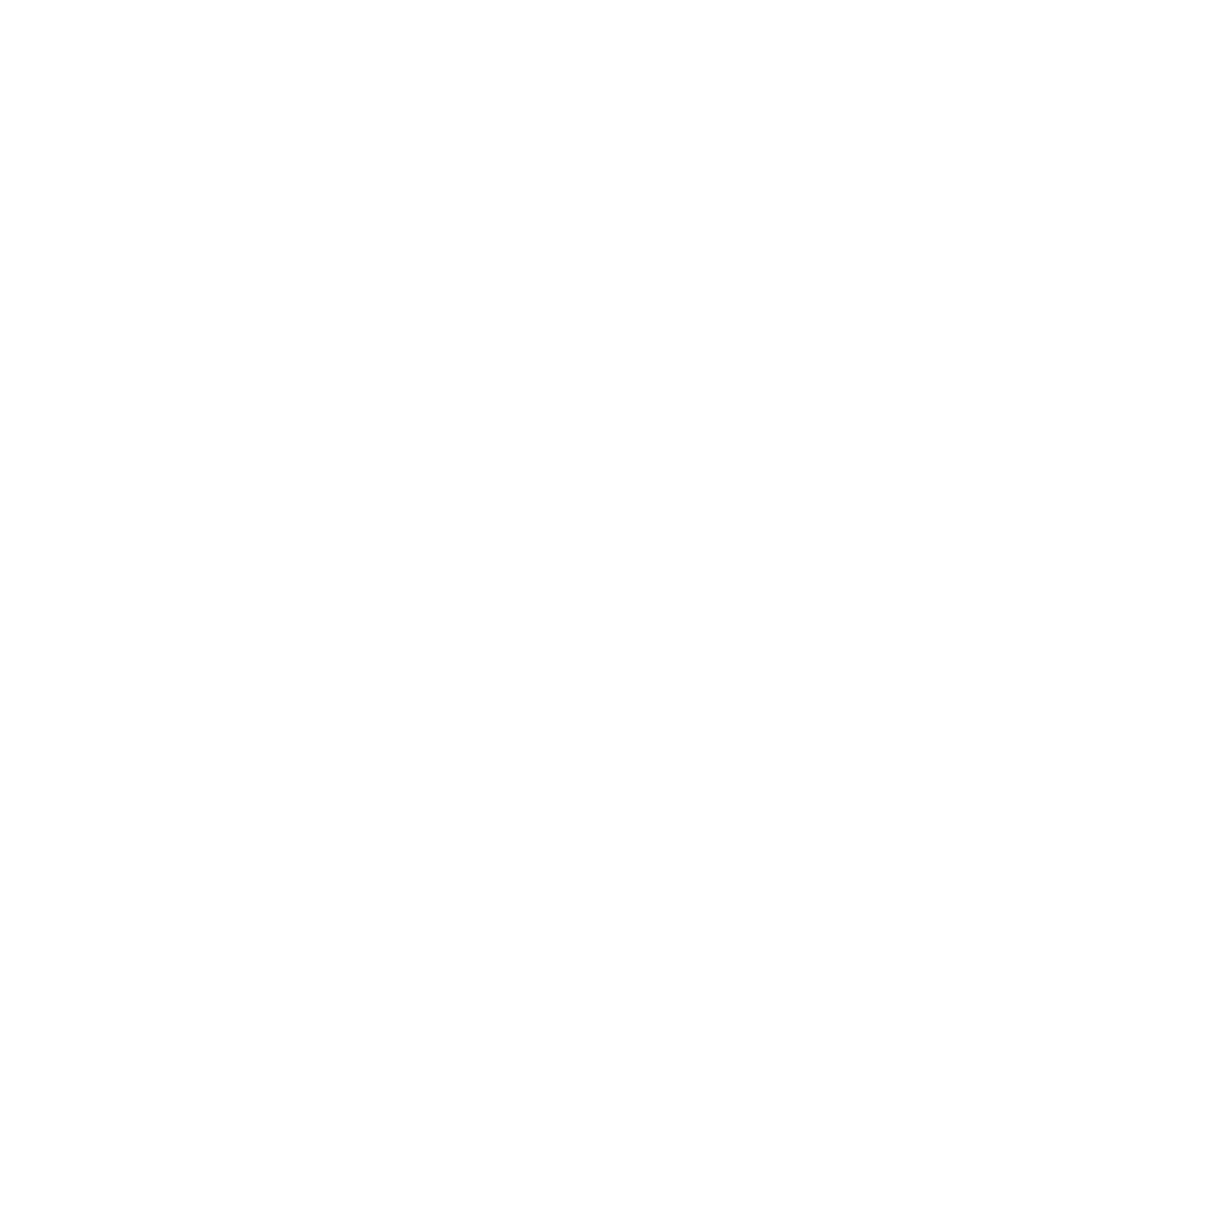

In [23]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="cost"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()